In [1]:
# std packages
%matplotlib inline
import numpy as np
import scipy.interpolate as interp
import scipy.integrate as integ
import scipy.signal as sig
import scipy.optimize as opt
import matplotlib.pyplot as plt
from matplotlib import rc
import h5py as h5
import os, sys
import timeit

plt.rc('figure', figsize=(9, 7))
plt.rcParams.update({'text.usetex': True,
                     'text.latex.preamble':r'\usepackage{amsmath}',
                     'font.family': 'serif',
                     'font.serif': ['Georgia'],
                     'mathtext.fontset': 'cm',
                     'lines.linewidth': 2.5,
                     'font.size': 20,
                     'xtick.labelsize': 'large',
                     'ytick.labelsize': 'large',
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.major.width': 1.7,
                     'ytick.major.width': 1.7,
                     'xtick.major.size': 7.,
                     'ytick.major.size': 7.,
                     'ytick.right':True, 
                     'axes.labelsize': 'large',
                     'axes.titlesize': 'large',
                     'axes.grid': True,
                     'grid.alpha': 0.5,
                     'lines.markersize': 12,
                     'legend.borderpad': 0.2,
                     'legend.fancybox': True,
                     'legend.fontsize': 17,
                     'legend.framealpha': 0.7,
                     'legend.handletextpad': 0.5,
                     'legend.labelspacing': 0.2,
                     'legend.loc': 'best',
                     'savefig.bbox': 'tight',
                     'savefig.pad_inches': 0.05,
                     'savefig.dpi': 80,
                     'pdf.compression': 9})


import lal
import lalsimulation as lals

# packages used to generate ODE-Phenom waveforms
from src.LAL_constants import *
from src import waveLib as wL
from src import misc

2048.0
f_max, delta_f: 2048.0 0.25


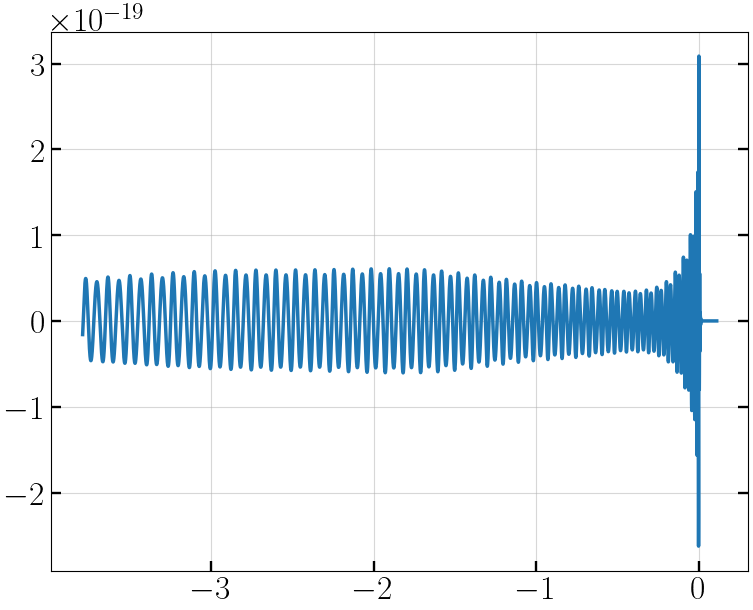

In [2]:
Mt_Ms = 50.
t_Mt = G*Mt_Ms*Ms/c**3.

### intrinsic parameters ###
qq = 1./4
M1_Ms, M2_Ms = Mt_Ms/(1.+qq), qq*Mt_Ms/(1.+qq)

chi1p, chi1z = 0.3, -0.7
phi_1 = 0.5 * np.pi
chi1x = chi1p * np.cos(phi_1)
chi1y = chi1p * np.sin(phi_1)

chi2p, chi2z = 0.5, -0.5
phi_2 = 0. * np.pi
chi2x = chi2p * np.cos(phi_2)
chi2y = chi2p * np.sin(phi_2)

### extrinsic parameters ###
dist_Mpc = 1
phi_ref = .7* np.pi 
iota = np.pi/3

# start and also reference freq for td waveforms
f_ref = 15

# lowest frequency to keep in f domain
f_lower=14.5


### SEOBNRv4PHM ###
# estimation of the sampling rate
f_max_est = 0.3/t_Mt 
f_max_est = 2.**np.ceil(np.log2(f_max_est))
print(f_max_est)

delta_t = 1./2/f_max_est

# first query SEOB waveform in time domain
lal_keys =[
    'phi_ref', 'delta_t',
    'm1_kg', 'm2_kg',
    'f_min', 'dist',
    'iota', 
    's1x', 's1y', 's1z', 's2x', 's2y', 's2z',
    'mode_array',
    'aux_par'
           ]
lal_dict = {
    'm1_kg': M1_Ms * Ms,
    'm2_kg': M2_Ms * Ms,
    's1x': chi1x, 
    's1y': chi1y,
    's1z': chi1z,
    's2x': chi2x,
    's2y': chi2y,
    's2z': chi2z,    
    'dist': dist_Mpc * 1e6 * pc,
    'iota': iota, 
    'phi_ref': phi_ref,
    'longAscNodes':0, 
    'ecc':0, 
    'meanPerAno':0,
    'delta_t': delta_t,
    'f_min': f_lower, 
    'f_ref': f_ref, 
    'mode_array':lals.SimInspiralCreateModeArray(),
    'aux_par': lal.CreateDict(), 
    'approximant': lals.GetApproximantFromString('SEOBNRv4PHM') 
}

ll_list_neg = np.array([ 2,  2,  3,  4,  5])
mm_list_neg = np.array([-2, -1, -3, -4, -5])

mm_list = np.hstack((mm_list_neg, -mm_list_neg))
ll_list = np.hstack((ll_list_neg, ll_list_neg))
mode_array = lals.SimInspiralCreateModeArray()
for i in range(len(mm_list)):
    lals.SimInspiralModeArrayActivateMode(lal_dict['mode_array'], int(ll_list[i]), int(mm_list[i]))
hp_td, hc_td, __, __, \
__, __, __, \
__,\
__, __, __, __, __,__, __, __, __, __, \
__, __, __,\
__\
 = lals.SimIMRSpinPrecEOBWaveformAll(*[lal_dict[key] for key in lal_keys])

hp_td = hp_td.data.data
hc_td = hc_td.data.data


# do an approximate timeshift correction so that t=0 corresponds to the max of waveform amplitude
tt = np.arange(0, len(hp_td)*delta_t, delta_t)
idx_max = np.argmax(hp_td**2. + hc_td**2.)
tt -= tt[idx_max]

t_dur = tt[-1] - tt[0]
n_td = t_dur / delta_t
n_td = 2.**np.ceil(np.log2(n_td))
t_dur = n_td * delta_t
delta_f = 1./t_dur    
print('f_max, delta_f:', .5/delta_t, delta_f)

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(tt, hp_td)


# transfer to the frequency domain and keep only f>0 part
freq, hp_SEOB = misc.get_fd_from_td(hp_td, delta_t, delta_f, t0=tt[0])
__,   hc_SEOB = misc.get_fd_from_td(hc_td, delta_t, delta_f, t0=tt[0])
 
idx = (freq>=f_lower) & (freq < 0.16/t_Mt)

freq = freq[idx]
hp_SEOB = hp_SEOB[idx]
hc_SEOB = hc_SEOB[idx]
n_pt = len(freq)

In [5]:
### IMRPhenomXODE ###

# modes in the co-precessing frame; 
# note only m<0 modes have f>0 support
ll_list_neg = np.array([ 2,  2,  3,  3,  4])
mm_list_neg = np.array([-2, -1, -3, -2, -4])

# define LAL like input
aux_par = lal.CreateDict()
kwargs_XODE = {
    'freqs':freq,
    'approximant': 'XODE',
    'll_list_neg':ll_list_neg,
    'mm_list_neg':mm_list_neg,
    'use_N4LO_prec':True,
    'SEOB_22_cal':True,
    'SEOB_HM_cal':True,
    'update_spin': False,
    'mass1':M1_Ms,
    'mass2':M2_Ms,
    'spin1x':chi1x, 
    'spin1y':chi1y,
    'spin1z':chi1z,
    'spin2x':chi2x, 
    'spin2y':chi2y,
    'spin2z':chi2z,
    'f_ref': f_ref,
    'phi_ref':phi_ref,
    'iota':iota,
    'f_lower': freq[0],
    'distance': dist_Mpc,    
    'aux_par':aux_par, 
    'atol':1e-3,
    'rtol':1e-3
}

# XODE
t_run0 = timeit.default_timer()
hp_XODE, hc_XODE = wL.get_hp_hc_f_sequence(**kwargs_XODE)
t_run1 = timeit.default_timer()

# it may take some time for compiling the code when running it the first time
# the subsequent evaluation should be efficient <~ 40 ms for the example
print('time (s) per waveform: ', t_run1 - t_run0)



### IMRPhenomXPHM ###
kwargs_XPHM = kwargs_XODE.copy()
# 102 for NNLO 223 for MSA
lals.SimInspiralWaveformParamsInsertPhenomXPrecVersion(kwargs_XPHM['aux_par'], 223)
kwargs_XPHM['approximant'] = 'XPHM'
hp_XPHM, hc_XPHM = wL.get_hp_hc_f_sequence(**kwargs_XPHM)

time (s) per waveform:  0.03981066299999725


In [6]:
f_min = f_ref + 0.125
f_max = np.infty

ASD = misc.read_mag(freq, 'aLIGO_design.txt')
PSD = ASD**2.

### form a signal using SEOB ###
# eq. 16 of Harry+ 2016, PRD 94, 024012 (2016)
# pol is kappa there
pol = 0.6*np.pi
ss = hp_SEOB * np.cos(pol) + hc_SEOB * np.sin(pol)

ss_norm = np.sqrt(misc.inner_prod(freq, ss, ss, PSD, f_min=f_min, f_max=f_max))
print('SNR:', ss_norm)
ss_normed = ss/ss_norm
ss_int = np.real(misc.inner_prod_integrand(freq, ss_normed, ss_normed, PSD))


### consider mismatches between SEOB and Phenom models ###

hh_pc_XODE = np.vstack((hp_XODE, hc_XODE))
hh_pc_XPHM = np.vstack((hp_XPHM, hc_XPHM))

# consistent Pratten+ 21
# max over time and phase shifts, polarization, phi_ref, and rigid rotation of the in-plane spins at f_ref
match_XODE, h0_XODE, xx_XODE = misc.opt_phi_ref_phi_az(ss_normed, PSD, kwargs_XODE, 
                    kappa_0 = pol, f_min=f_min, f_max=f_max, 
                    dual_annealing = True)
print('Mismatch (XODE vs SEOB):', 1.-match_XODE)

match_XPHM, h0_XPHM, xx_XPHM = misc.opt_phi_ref_phi_az(ss_normed, PSD, kwargs_XPHM, 
                    kappa_0 = pol, f_min=f_min, f_max=f_max, 
                    dual_annealing = True)
print('Mismatch (XPHM vs SEOB):', 1.-match_XPHM)

SNR: 10495.995642316304
Mismatch (XODE vs SEOB): 0.004680491599329595
Mismatch (XPHM vs SEOB): 0.05313547054239587


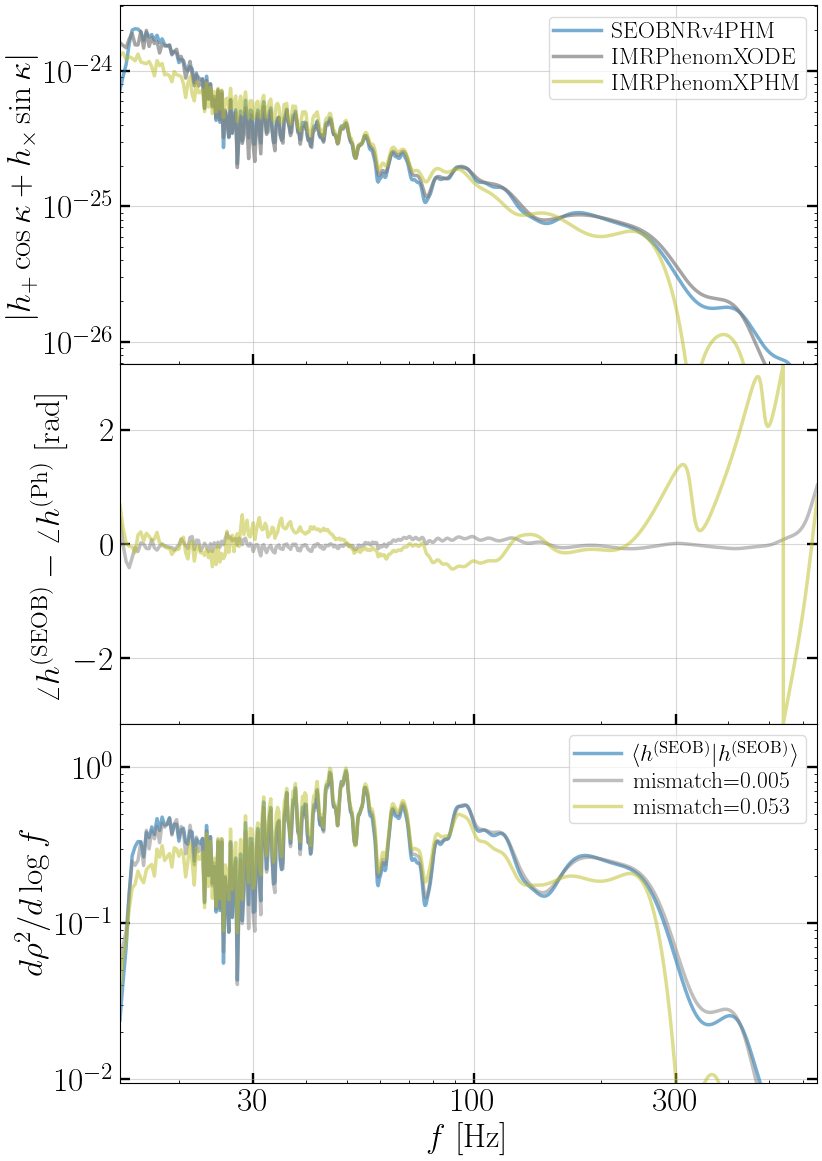

In [7]:
### plot the results ###

h0_XODE_norm = np.sqrt(misc.inner_prod(freq, h0_XODE, h0_XODE, PSD, f_min=f_min, f_max=f_max))
ang_diff_XODE = np.angle(ss_normed*h0_XODE.conj())
match_XODE_int = np.real(misc.inner_prod_integrand(freq, ss_normed, h0_XODE/h0_XODE_norm, PSD))

h0_XPHM_norm = np.sqrt(misc.inner_prod(freq, h0_XPHM, h0_XPHM, PSD, f_min=f_min, f_max=f_max))
ang_diff_XPHM = np.angle(ss_normed*h0_XPHM.conj())
match_XPHM_int = np.real(misc.inner_prod_integrand(freq, ss_normed, h0_XPHM/h0_XPHM_norm, PSD))


fig=plt.figure(figsize=(9, 14))
ax1=fig.add_subplot(311)
ax1.loglog(freq, np.abs(ss_normed), color='tab:blue', alpha=0.6,
           label=r'SEOBNRv4PHM')
ax1.loglog(freq, np.abs(h0_XODE/h0_XODE_norm), color='tab:gray', alpha=0.7,
           label=r'IMRPhenomXODE')
ax1.loglog(freq, np.abs(h0_XPHM/h0_XPHM_norm), color='tab:olive', alpha=0.5, ls='-',
           label=r'IMRPhenomXPHM')
ax1.set_ylabel(r'$|h_+ \cos \kappa + h_\times \sin \kappa|$')
ax1.legend(loc='upper right')
ax1.set_ylim([np.max(np.abs(ss_normed))/3e2, np.max(np.abs(ss_normed))*1.5])
ax1.set_xlim([f_lower, 0.16/t_Mt])
ax1.set_xticks([30, 100, 300])
ax1.set_xticklabels([])



ax2=fig.add_subplot(312)
idx = [i for i in range(n_pt) if freq[i]>=f_min*0.95 and freq[i]<f_max*1.05]
# ax2.semilogx(freq[idx], ang_diff_NLO[idx], alpha=0.5)
ax2.semilogx(freq[idx], ang_diff_XODE[idx], alpha=0.5, color='tab:gray')
ax2.semilogx(freq[idx], ang_diff_XPHM[idx], alpha=0.5, color='tab:olive', ls='-')
ax2.set_xlim(ax1.get_xlim())

ax2.set_ylim([-np.pi, np.pi])
ax2.set_ylabel(r'$\angle h^{\rm (SEOB)} - \angle h^{\rm (Ph)}$ [rad]')

ax2.set_xticks([30, 100, 300])
ax2.set_xticklabels([])



ax3=fig.add_subplot(313)
ax3.loglog(freq, np.abs(freq*ss_int), color='tab:blue', alpha=0.6,  
           label=r'$\langle h^{\rm (SEOB)}|h^{\rm (SEOB)} \rangle$')
ax3.loglog(freq, np.abs(freq*match_XODE_int), 
           color='tab:gray', alpha=0.5, label='mismatch=%.3f'%(1-match_XODE))
ax3.loglog(freq, np.abs(freq*match_XPHM_int), 
           color='tab:olive', alpha=0.5, ls='-', label=r'mismatch=%.3f'%(1-match_XPHM))

ax3.set_xticks([30, 100, 300])
ax3.set_xticklabels([30, 100, 300])
ax3.set_ylabel(r'$d \rho^2 / d \log f$')
ax3.set_xlabel(r'$f$ [Hz]')
ax3.set_ylim([np.max(np.abs(freq*ss_int))*1.e-2, np.max(np.abs(freq*ss_int))*2.])
ax3.set_xlim(ax1.get_xlim())
ax3.legend(loc='upper right')
plt.subplots_adjust(hspace=0)